# Python Basics


In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf


DJ = pd.read_csv("csv/60M/XAUUSD_H1_202201110100_202205022300.csv",delim_whitespace=True)
timeFrame = int(input('TimeFrame:'))
CandlesInDay = 24 * (60//timeFrame)
DJ.insert(7, '<CANDLESIZE>',value=0)
DJ.insert(8, '<SIZE>',value=0)
DJ.drop(['<HIGH>','<LOW>','<TICKVOL>','<VOL>','<SPREAD>'],axis=1,inplace=True)
DJ['<CANDLESIZE>'] =  DJ['<CLOSE>'] > DJ['<OPEN>']
DJ['<SIZE>'] =  DJ['<CLOSE>'] - DJ['<OPEN>']



In [141]:
def candleToTime(j):
    k=j//minuteMult
    sth=timeFrame*(j%minuteMult)
    return '{:02d}:{:02d}:00'.format(k,sth)

uniqueDays = DJ.drop_duplicates(subset='<DATE>')
uniqueDays = pd.DataFrame(uniqueDays)

uniqueDaysCount=uniqueDays.shape[0]


newDF = pd.DataFrame(columns=['<DATE>','<TIME>','<OPEN>','<CLOSE>','<CANDLESIZE>','<SIZE>'])

minuteMult = CandlesInDay//24



for i in range(uniqueDays.shape[0]):
    for j in range(CandlesInDay):
        
        newDF.loc[(i*CandlesInDay)+j]=[uniqueDays.iloc[i][0],candleToTime(j),0,0,0,0]


In [142]:
newestDF = newDF.merge(DJ,on=['<DATE>','<TIME>'],how='left')

newestDF.drop(columns=['<OPEN>_x','<CLOSE>_x','<SIZE>_x','<CANDLESIZE>_x','<CLOSE>_y','<OPEN>_y'],inplace=True)
newestDF['<CANDLESIZE>_y'] = newestDF['<CANDLESIZE>_y'].fillna(0)
newestDF['<SIZE>_y'] = newestDF['<SIZE>_y'].fillna(0)



In [143]:
list = []
for i in range(len(newestDF)):
    date = newestDF.iloc[i][0]
    time = newestDF.iloc[i][1]
    GreenOrRed = newestDF.iloc[i][2]
    size = newestDF.iloc[i][3]
    list.append([date, time, GreenOrRed,size])


In [144]:
days = []
for i in range(uniqueDaysCount): 
    days.append(list[i*CandlesInDay: CandlesInDay*(i+1)])


<AxesSubplot:>

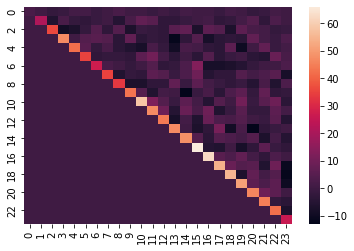

In [156]:


def eachDayMat(day):
    avg=0
    for i in range(len(day)):
        avg+=abs(day[i][3])
    avg/=len(day)
    ansMatrix = np.zeros((CandlesInDay,CandlesInDay),dtype=int)
    for i in range(len(day)) : 
        for j in range (i,len(day)):
            if abs(day[i][3])> avg/1.5 and abs(day[j][3])> avg/1.5:
                ansMatrix[i][j]=1 if not(day[i][2] ^ day[j][2]) else -1
                continue
            ansMatrix[i][j]=0
            

    return ansMatrix

ansVector = []
for i in range(len(days)):
    
    ansVector.append(eachDayMat(days[i]))

final = np.sum(ansVector, axis=0)
# final-=len(days)//2
sns.heatmap(final)
# plt.imshow(final)

In [157]:
bias=.65
consecutiveOnly = False
# float(input('Bias:')) 



for i in range(len(final)):
    for j in range (i,len(final)):
        prob = abs(final[i][j]) / uniqueDaysCount + 0.5
        if (bias<prob<1)and (not i==j):
            prob100 = int(prob*10000)/100
            if(j-i==1):

                print(f"Consecutive: {i}-{j}",f"{candleToTime(i)}-{candleToTime(j)}",f"{prob100}% ++") if final[i][j]>=0 else print(f"Consecutive: {i}-{j}",f"{candleToTime(i)}-{candleToTime(j)}",f"{prob100}% --")
                continue
                    
            if not(consecutiveOnly):
                print(f"{i}-{j}",f"{candleToTime(i)}-{candleToTime(j)}",f"{prob100}% ++") if final[i][j]>=0 else print(f"{i}-{j}",f"{candleToTime(i)}-{candleToTime(j)}",f"{prob100}% --")





3-13 03:00:00-13:00:00 65.18% --
6-15 06:00:00-15:00:00 66.45% ++
9-14 09:00:00-14:00:00 66.45% --
Consecutive: 10-11 10:00:00-11:00:00 65.18% ++
13-20 13:00:00-20:00:00 66.45% --
18-23 18:00:00-23:00:00 65.18% --
